## 1) Loading Data and Packages + Util

In [3]:
import os
from google.colab import files
import shutil

import math
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, RandomizedSearchCV, GridSearchCV, TunedThresholdClassifierCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import get_scorer_names, balanced_accuracy_score
import matplotlib.pyplot as plt
from typing_extensions import final
import seaborn as sns
import random

from collections import OrderedDict

Load data from local folder

In [5]:
os.makedirs('/content/data', exist_ok=True)
destination_folder = '/content/data'
uploaded = files.upload()
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(destination_folder, filename))

Saving all_fitbit_data_daily_w_visit.csv to all_fitbit_data_daily_w_visit.csv
Saving data_daily_w_visits.csv to data_daily_w_visits.csv
Saving adh.csv to adh.csv


Setup fitbit_data

In [6]:
fitbit_data = pd.read_csv('/content/data/data_daily_w_visits.csv')
all_fitbit_data = pd.read_csv('/content/data/all_fitbit_data_daily_w_visit.csv')
full_fb_data = pd.read_csv('/content/data/full_fb_data.csv')
adh_data = pd.read_csv('/content/data/adh.csv')

In [7]:
# Organizing columns
measure_features = ['calories', 'heart', 'steps']
survey_features = ['diet', 'medication', 'symptoms']
target_col = 'visit_day'
all_features = ['avgWeight_per_day',
       'calories', 'heart', 'steps', 'minutes_asleep', 'minutes_awake', 'temp/skin_nightlyRelative',
       'spo2_avg', 'spo2_min', 'spo2_max', 'hrv_dailyRmssd', 'hrv_deepRmssd',
       'br_breathingRate', 'out_of_range_zone_cal', 'out_of_range_zone_max_hr',
       'out_of_range_zone_min_hr', 'fat_burn_zone_cal', 'fat_burn_zone_max_hr',
       'fat_burn_zone_min_hr', 'cardio_zone_cal', 'cardio_zone_max_hr',
       'cardio_zone_min_hr', 'peak_zone_cal', 'peak_zone_max_hr',
       'peak_zone_min_hr', 'diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']
one_h_feaatures = ['diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']
adh_info = ['synced_fitbit', 'checked_weight',	'did_survey',	'fb_streak',
            'bt_streak',	'surv_streak', 'above_min_thresh',
            'percent_of_day_worn',	'above_thresh']

In [8]:
# Ensure date is datetime and sort
fitbit_data['date'] = pd.to_datetime(fitbit_data['date'])
fitbit_data = fitbit_data.sort_values(by=['fitbit_user_id', 'date'])
all_fitbit_data['date'] = pd.to_datetime(all_fitbit_data['date'])
all_fitbit_data = all_fitbit_data.sort_values(by=['fitbit_user_id', 'date'])
full_fb_data['date'] = pd.to_datetime(full_fb_data['date'])
full_fb_data = full_fb_data.sort_values(by=['fitbit_user_id', 'date'])

# Shift survey columns
for col in survey_features:
  fitbit_data[col] = fitbit_data.groupby('fitbit_user_id')[col].shift(-1)
  all_fitbit_data[col] = all_fitbit_data.groupby('fitbit_user_id')[col].shift(-1)
  full_fb_data[col] = full_fb_data.groupby('fitbit_user_id')[col].shift(-1)

# Set remaining nan visit columns to 0
fitbit_data[target_col] = fitbit_data[target_col].fillna(0)
all_fitbit_data[target_col] = all_fitbit_data[target_col].fillna(0)
full_fb_data[target_col] = full_fb_data[target_col].fillna(0)

In [9]:
full_fb_data['has_visit'] = 0

for user_id, group in full_fb_data.groupby('fitbit_user_id'):
    if group[target_col].sum() != 0:
        full_fb_data.loc[group.index, 'has_visit'] = 1

In [10]:
def zscore_userwise(df, features):
    df_z = df.copy()
    for col in features:
        means = df.groupby('fitbit_user_id')[col].transform('mean')
        stds  = df.groupby('fitbit_user_id')[col].transform('std')
        df_z[col + '_z'] = (df[col] - means) / stds
    return df_z

In [11]:
z_features = ['avgWeight_per_day', 'calories', 'heart', 'steps', 'hrv_dailyRmssd', 'hrv_deepRmssd']

z_fb_data = zscore_userwise(full_fb_data, z_features)

In [12]:
def extract_days_before_visit(df, days_before=14):
    output_rows = []

    for user_id, group in df.groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)
        visit_indices = group.index[group['visit_day'] == 1].tolist()

        if not visit_indices:
            continue  # Skip users with no visits

        first_visit_idx = visit_indices[0]
        visit_day = group.loc[first_visit_idx, 'days']

        # Slice window before visit
        visit_window = group[(group['days'] >= visit_day - days_before) & (group['days'] <= visit_day)].copy()

        # Add relative day to visit
        visit_window['days_to_visit'] = visit_window['days'] - visit_day
        visit_window['fitbit_user_id'] = user_id

        output_rows.append(visit_window)

    result_df = pd.concat(output_rows, axis=0).reset_index(drop=True)

    return result_df

In [13]:
def extract_days_no_visits(df, window_days=15, max_windows=3, seed=42):
    np.random.seed(seed)
    output_rows = []

    for user_id, group in df[df['has_visit'] == 0].groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)

        min_day = group['days'].min()
        max_day = group['days'].max()

        possible_starts = list(range(min_day, max_day - window_days + 1))
        np.random.shuffle(possible_starts)

        windows_added = 0

        for start in possible_starts:
            end = start + window_days
            window = group[(group['days'] >= start) & (group['days'] < end)].copy()

            if len(window) == window_days:  # Complete window
                window['days_to_window'] = window['days'] - end + 1
                window['fitbit_user_id'] = user_id
                output_rows.append(window)
                windows_added += 1

            if windows_added >= max_windows:
                break

    return pd.concat(output_rows, axis=0).reset_index(drop=True)

In [14]:
two_week_visit = extract_days_before_visit(z_fb_data)
three_week_visit = extract_days_before_visit(z_fb_data, days_before=21)
two_week = extract_days_no_visits(z_fb_data)
three_week = extract_days_no_visits(z_fb_data, window_days=22)

In [58]:
two_week

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,diet,medication,...,percent_of_day_worn,above_thresh,has_visit,avgWeight_per_day_z,calories_z,heart_z,steps_z,hrv_dailyRmssd_z,hrv_deepRmssd_z,days_to_window
0,135,2021-12-09,App Money,1,220.462000,2423.0,61.0,3149.0,NaN,NaN,...,0.675000,1,0,-1.030152,-0.843576,-1.189101,-0.909884,NaN,NaN,-14
1,136,2021-12-10,App Money,1,223.107544,2952.0,61.0,8310.0,2.0,1.0,...,0.684722,1,0,-0.405511,0.738222,-1.189101,1.229473,NaN,NaN,-13
2,137,2021-12-11,App Money,1,223.548468,2426.0,61.0,3424.0,2.0,2.0,...,0.631250,1,0,-0.301404,-0.834605,-1.189101,-0.795890,NaN,NaN,-12
3,138,2021-12-12,App Money,1,223.217775,3131.0,61.0,8669.0,NaN,NaN,...,0.616667,1,0,-0.379484,1.273462,-1.189101,1.378287,NaN,NaN,-11
4,139,2021-12-13,App Money,1,222.666620,2584.0,60.0,4924.0,2.0,2.0,...,0.672222,1,0,-0.509618,-0.362159,-1.751858,-0.174105,NaN,NaN,-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8905,44722,2024-12-09,No App,307,NaN,2120.0,56.0,3160.0,NaN,NaN,...,0.586111,1,0,NaN,-0.879743,-1.576522,-1.127575,NaN,NaN,-4
8906,44723,2024-12-10,No App,307,NaN,2851.0,56.0,4713.0,NaN,NaN,...,0.600694,1,0,NaN,0.376569,-1.576522,-0.558701,NaN,NaN,-3
8907,44724,2024-12-11,No App,307,201.502268,2168.0,57.0,3707.0,NaN,NaN,...,0.578472,1,0,0.498515,-0.797249,-1.281920,-0.927205,NaN,NaN,-2
8908,44725,2024-12-12,No App,307,NaN,3556.0,57.0,10924.0,NaN,NaN,...,0.587500,1,0,NaN,1.588196,-1.281920,1.716429,NaN,NaN,-1


## 2) Graphing

In [15]:
def plot_feature_comparison(df1, df2, feature, time_col1='days_to_visit', time_col2='days_to_window', label1='Visit Users', label2='No-Visit Users', bin_continuous=False, n_bins=10):
    # ------------------- Line Plot -------------------
    fig, ax = plt.subplots(figsize=(7, 4))

    # Group by time and compute mean
    avg1 = df1.groupby(time_col1)[feature].mean()
    avg2 = df2.groupby(time_col2)[feature].mean()

    ax.plot(avg1.index, avg1.values, marker='o', label=label1)
    ax.plot(avg2.index, avg2.values, marker='o', label=label2)

    ax.set_title(f"Average {feature} Over Time")
    ax.set_xlabel("Days")
    ax.set_ylabel(f"Average {feature}")
    ax.axvline(0, color='red', linestyle='--', label='Event Day')
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

     # ------------------- Stacked Bar Plots -------------------
    def prepare_for_stacked(df, label, tcol):
        df = df.copy()

        if bin_continuous:
            # Mark as "Missing" or "Non-missing" only
            df[feature] = df[feature].apply(lambda x: 'Missing' if pd.isna(x) else 'Non-missing')
        else:
            # Treat as categorical: fill NaNs and cast to string
            df[feature] = df[feature].fillna('Missing').astype(str)

        return df.groupby([tcol, feature]).size().unstack(fill_value=0)

    ct1 = prepare_for_stacked(df1, label1, time_col1)
    ct2 = prepare_for_stacked(df2, label2, time_col2)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # y-axes not shared

    ct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1})")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Count")

    ct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2})")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()


In [43]:
def drop_nan_user(df, feature):
    valid_users = df.groupby('fitbit_user_id')[feature].apply(lambda x: not x.isna().all())
    valid_user_ids = valid_users[valid_users].index

    return df[df['fitbit_user_id'].isin(valid_user_ids)].reset_index(drop=True)

### 2a) Three Week

In [44]:
three_week_visit_weight = drop_nan_user(three_week_visit, 'avgWeight_per_day_z')
three_week_weight = drop_nan_user(three_week, 'avgWeight_per_day_z')

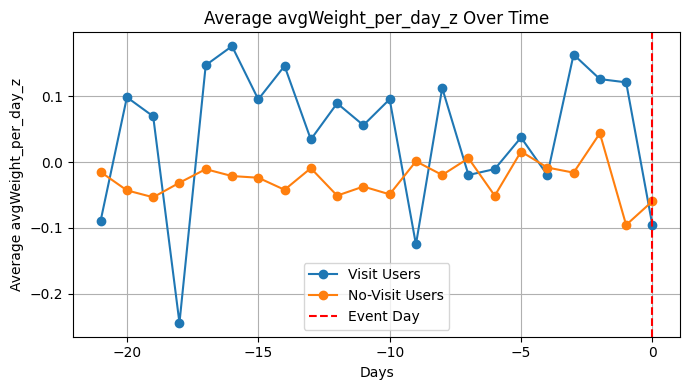

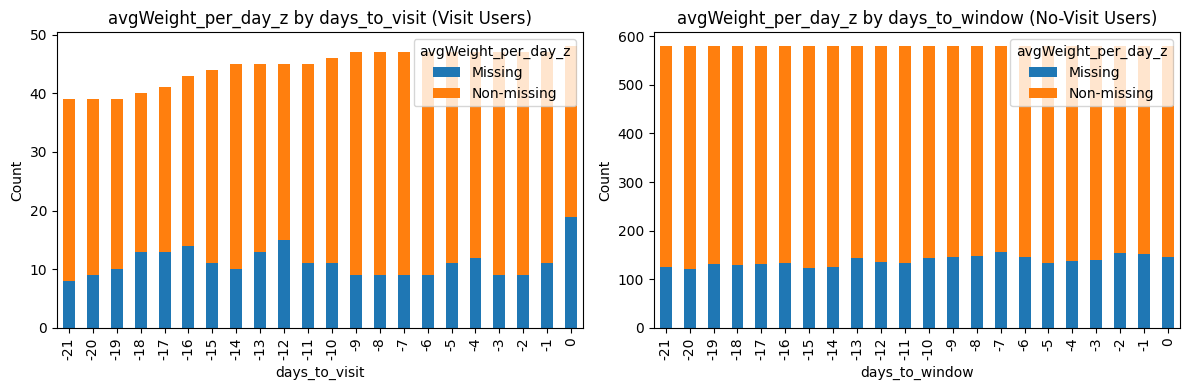

In [45]:
plot_feature_comparison(three_week_visit_weight, three_week_weight, 'avgWeight_per_day_z', bin_continuous=True, n_bins=10)

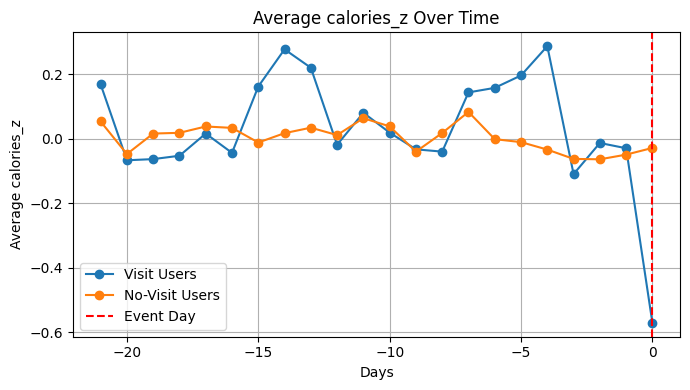

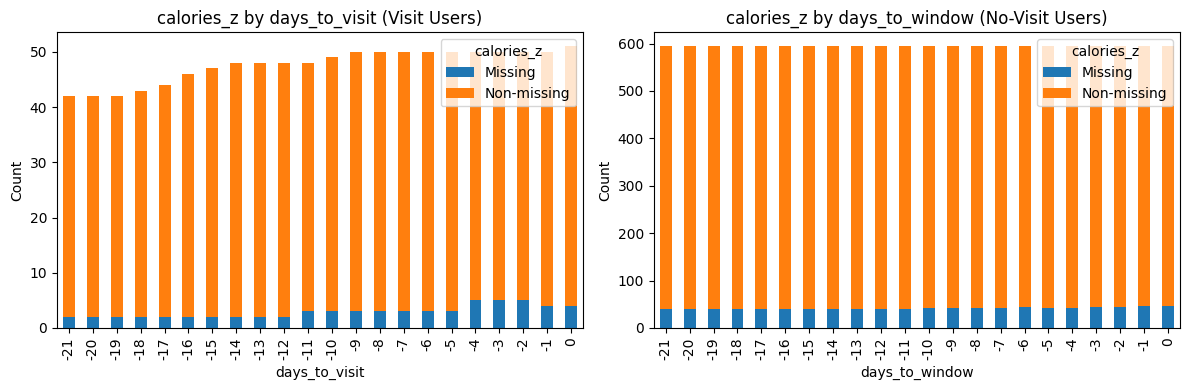

In [19]:
plot_feature_comparison(three_week_visit, three_week, 'calories_z', bin_continuous=True, n_bins=10)

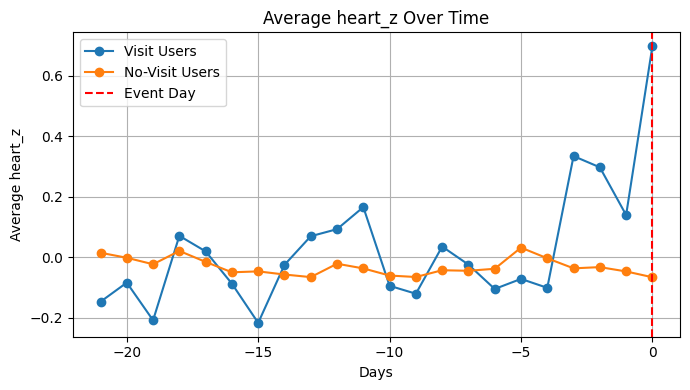

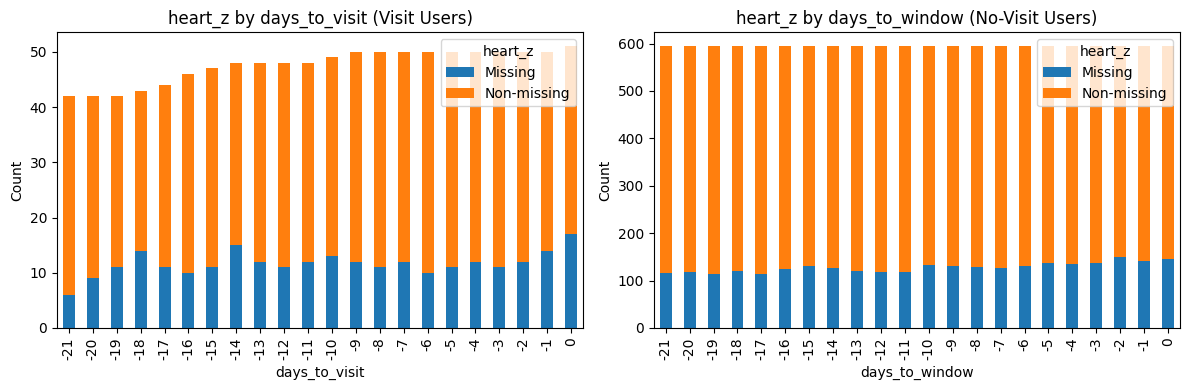

In [20]:
plot_feature_comparison(three_week_visit, three_week, 'heart_z', bin_continuous=True, n_bins=10)

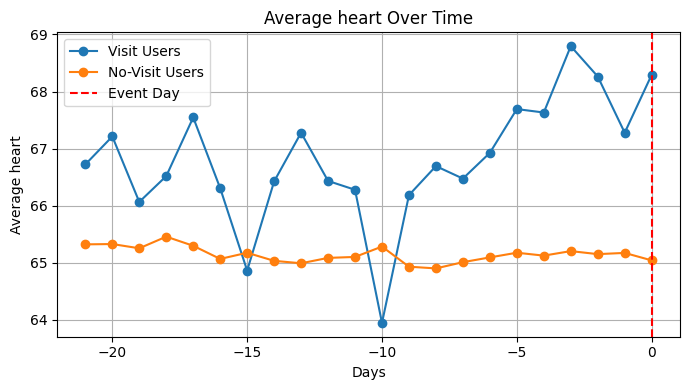

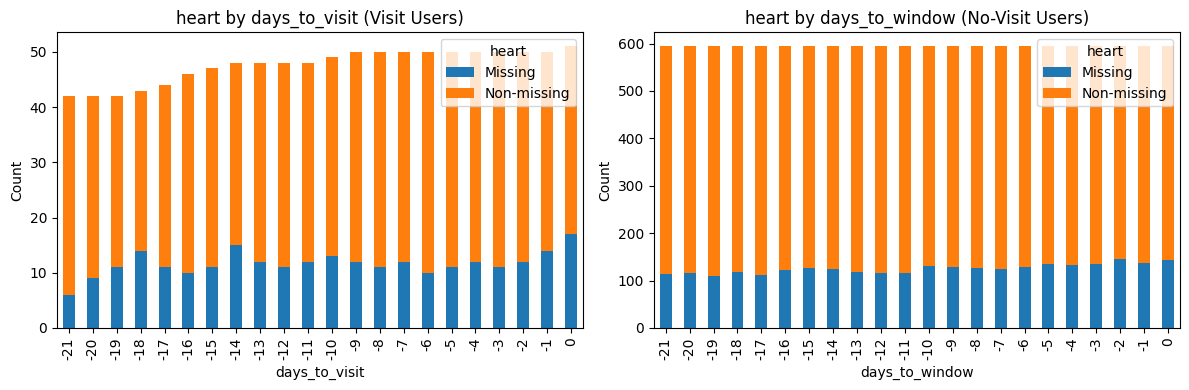

In [42]:
plot_feature_comparison(three_week_visit, three_week, 'heart', bin_continuous=True, n_bins=10)

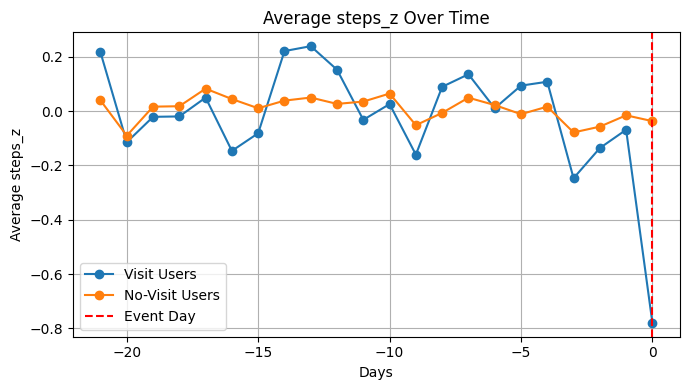

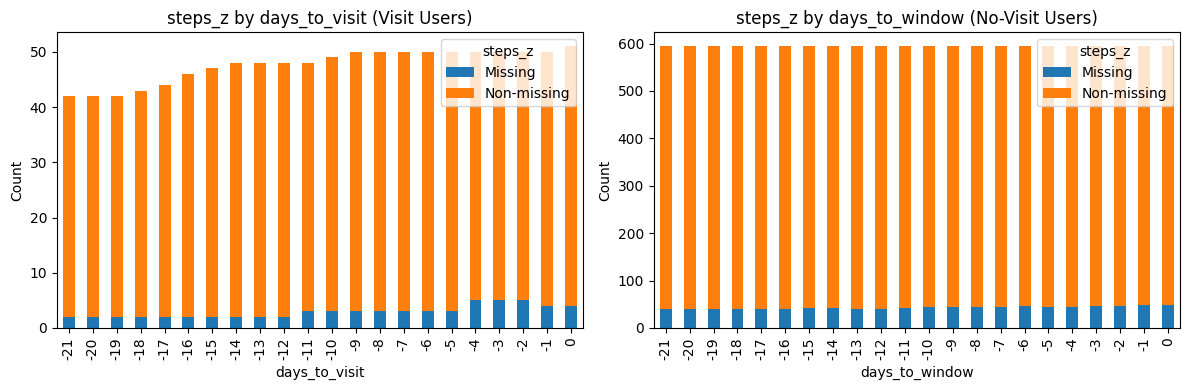

In [21]:
plot_feature_comparison(three_week_visit, three_week, 'steps_z', bin_continuous=True, n_bins=10)

In [52]:
three_week_visit_symptoms = drop_nan_user(three_week_visit, 'symptoms')
three_week_symptoms = drop_nan_user(three_week, 'symptoms')

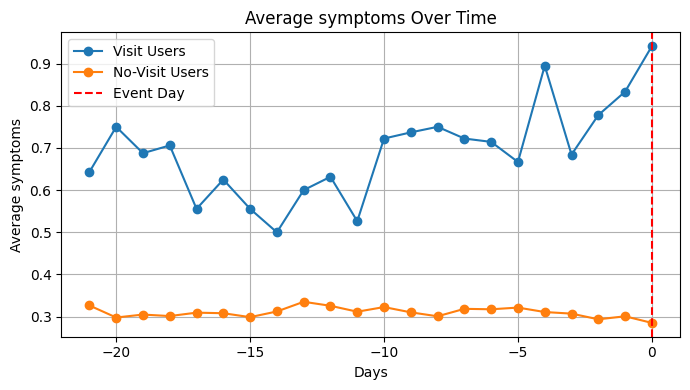

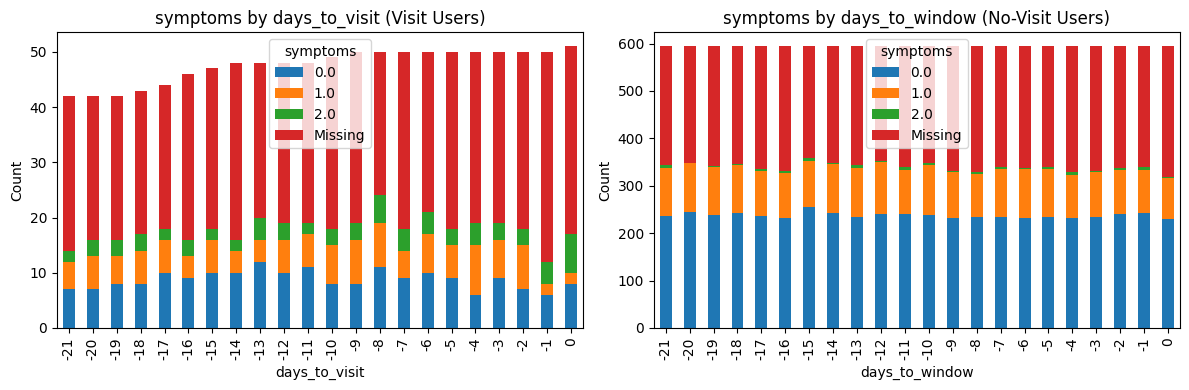

In [53]:
plot_feature_comparison(three_week_visit, three_week, 'symptoms', bin_continuous=False)

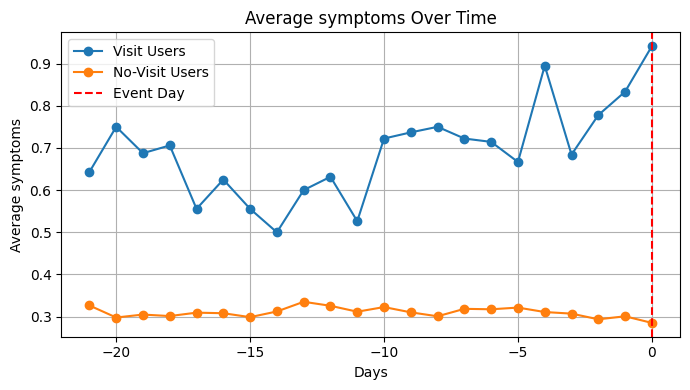

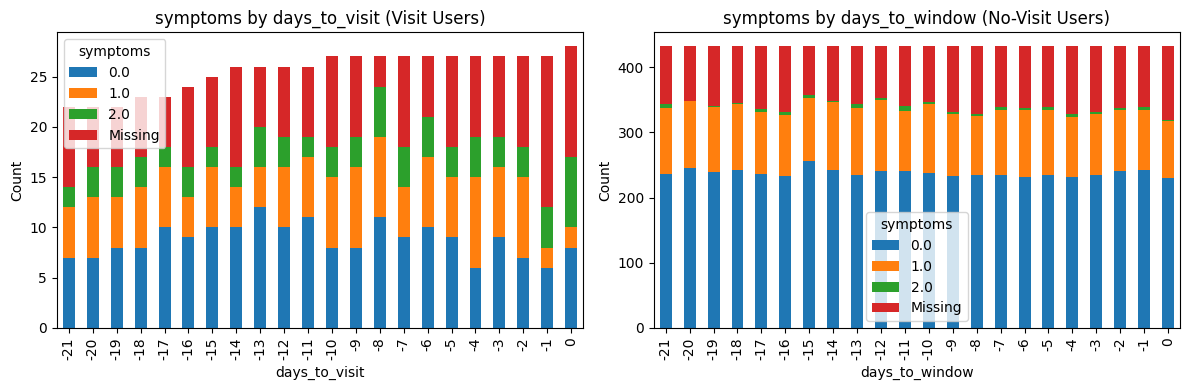

In [54]:
plot_feature_comparison(three_week_visit_symptoms, three_week_symptoms, 'symptoms', bin_continuous=False)

In [50]:
three_week_visit_hrv_deep = drop_nan_user(three_week_visit, 'hrv_deepRmssd_z')
three_week_hrv_deep = drop_nan_user(three_week, 'hrv_deepRmssd_z')

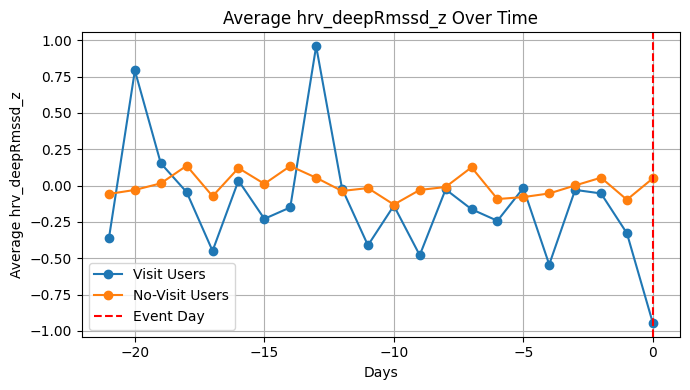

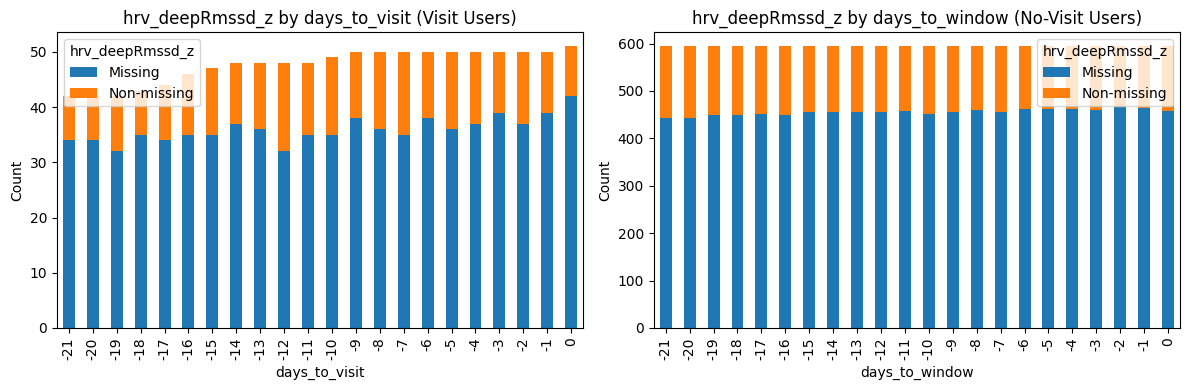

In [23]:
plot_feature_comparison(three_week_visit, three_week, 'hrv_deepRmssd_z', bin_continuous=True)

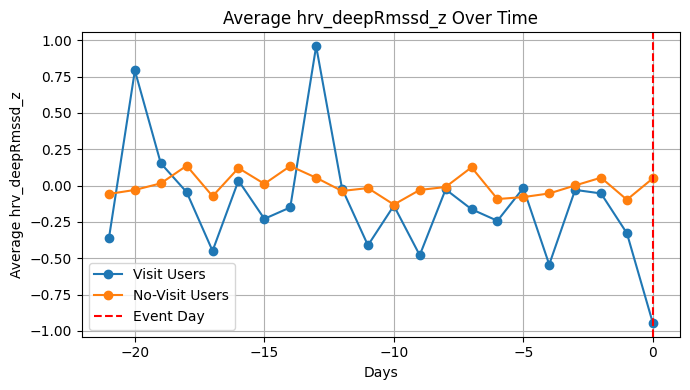

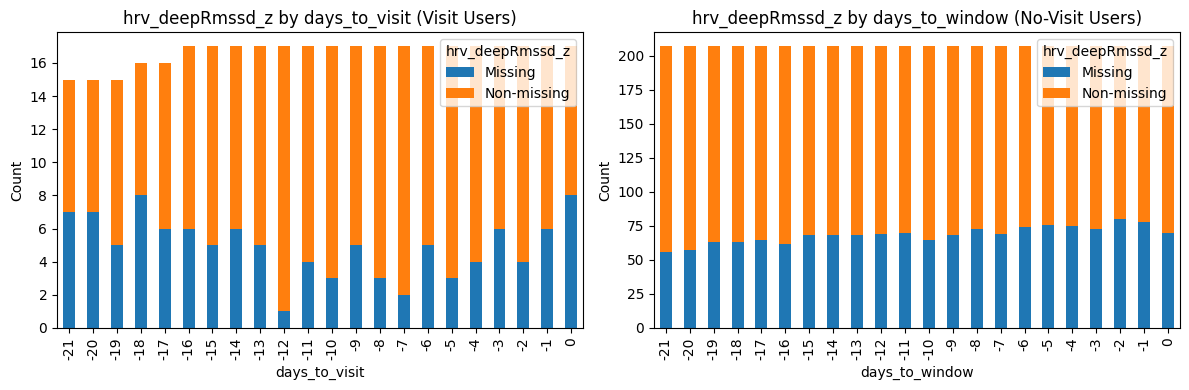

In [51]:
plot_feature_comparison(three_week_visit_hrv_deep, three_week_hrv_deep, 'hrv_deepRmssd_z', bin_continuous=True)

In [46]:
three_week_visit_hrv_daily = drop_nan_user(three_week_visit, 'hrv_dailyRmssd_z')
three_week_hrv_daily = drop_nan_user(three_week, 'hrv_dailyRmssd_z')

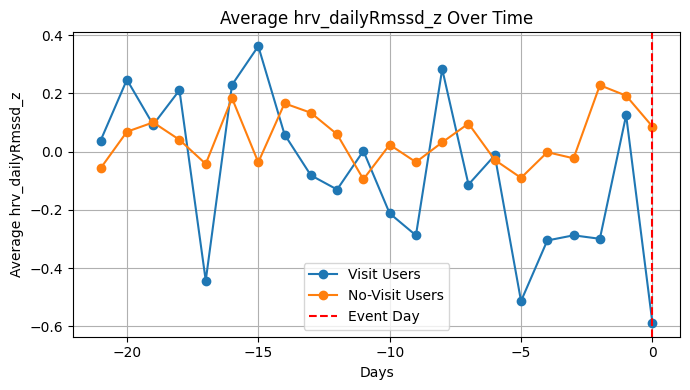

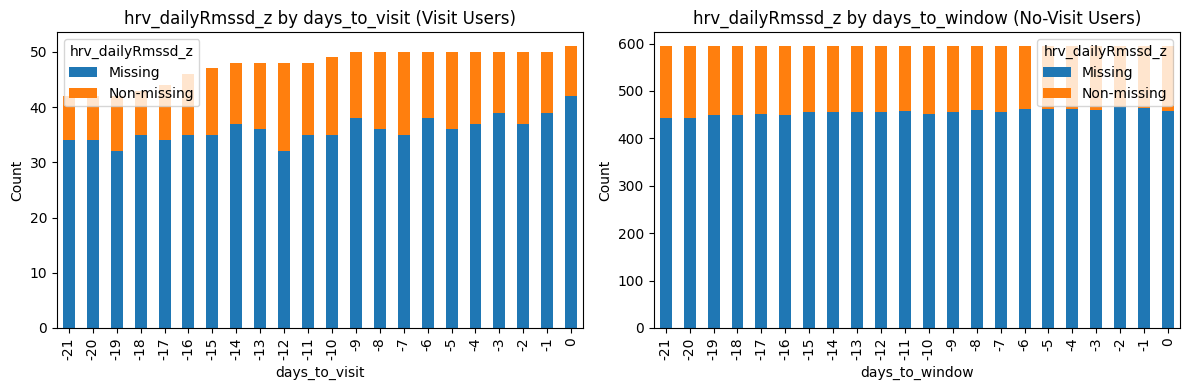

In [48]:
plot_feature_comparison(three_week_visit, three_week, 'hrv_dailyRmssd_z', bin_continuous=True)

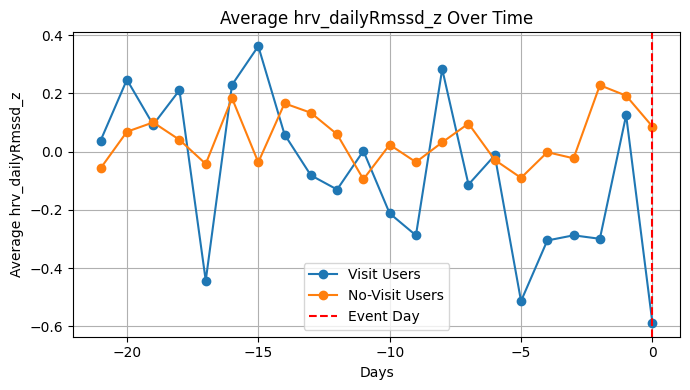

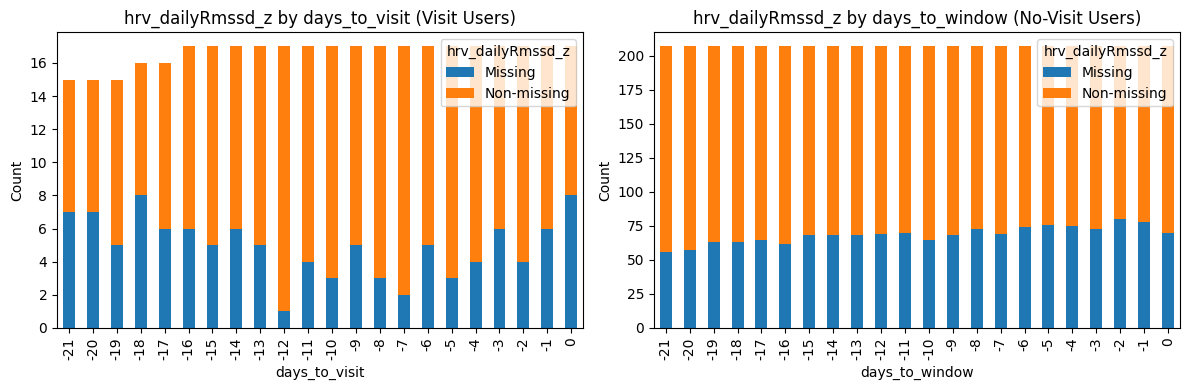

In [47]:
plot_feature_comparison(three_week_visit_hrv_daily, three_week_hrv_daily, 'hrv_dailyRmssd_z', bin_continuous=True)

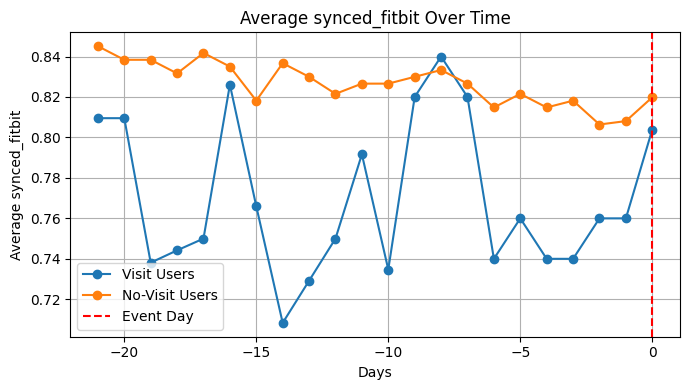

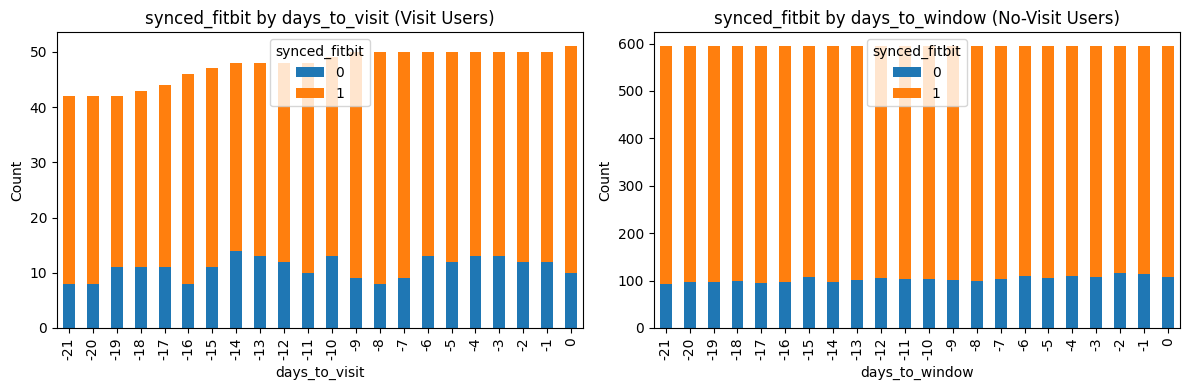

In [25]:
plot_feature_comparison(three_week_visit, three_week, 'synced_fitbit', bin_continuous=False)

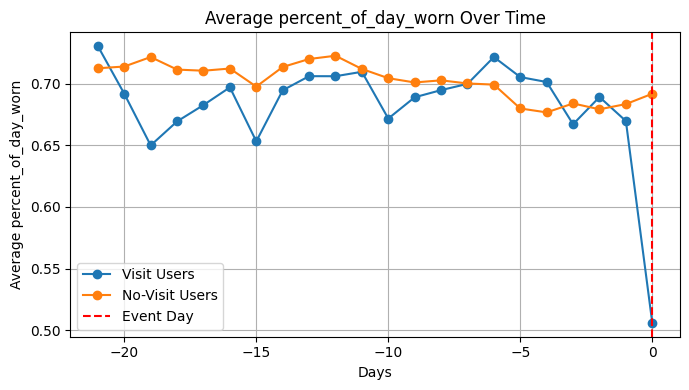

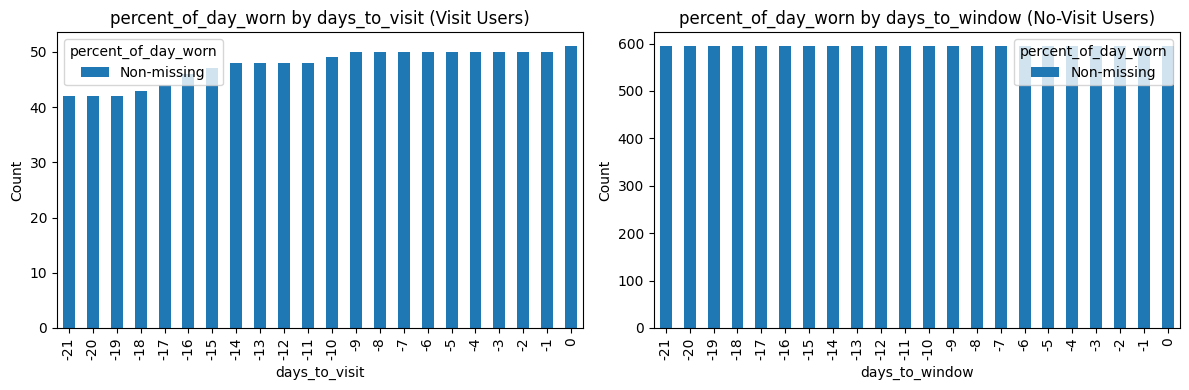

In [26]:
plot_feature_comparison(three_week_visit, three_week, 'percent_of_day_worn', bin_continuous=True)

In [27]:
three_week_visit_app = three_week_visit[three_week_visit['study_group'] != 'No App']
three_week_app = three_week[three_week['study_group'] != 'No App']

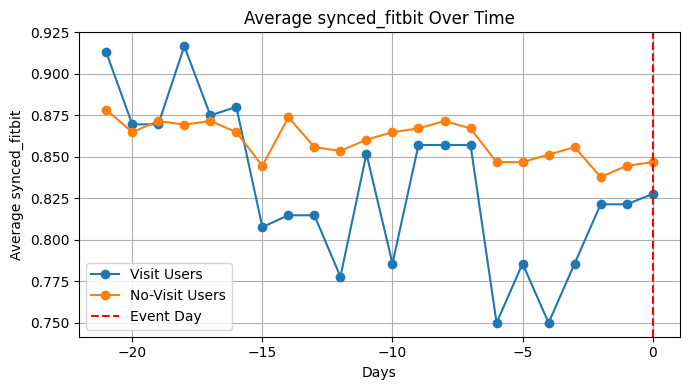

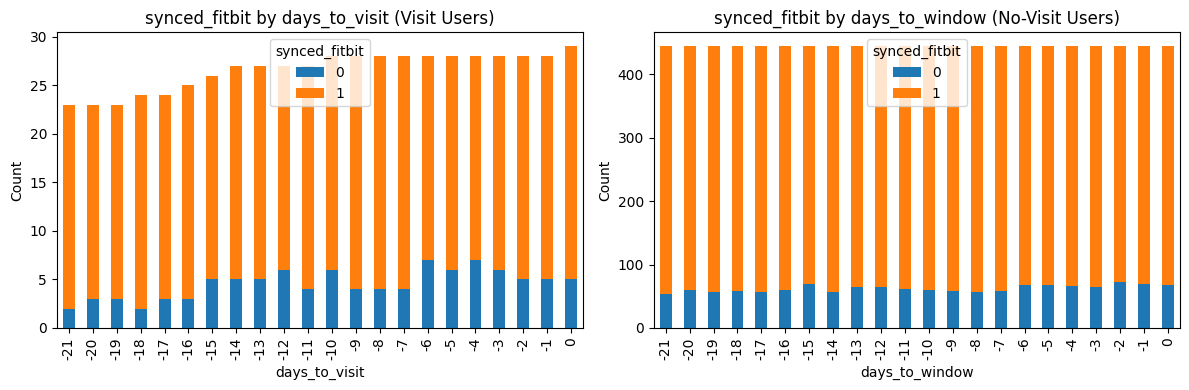

In [28]:
plot_feature_comparison(three_week_visit_app, three_week_app, 'synced_fitbit', bin_continuous=False)

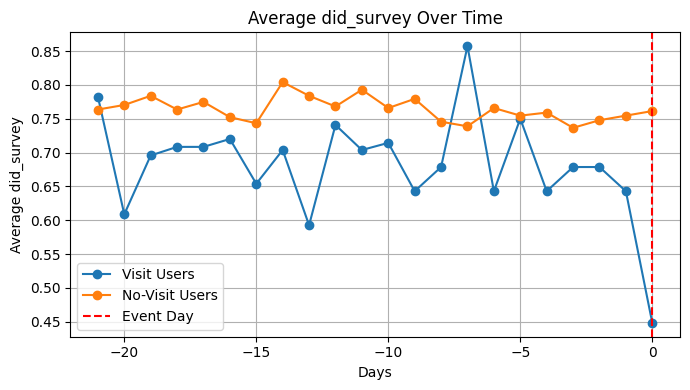

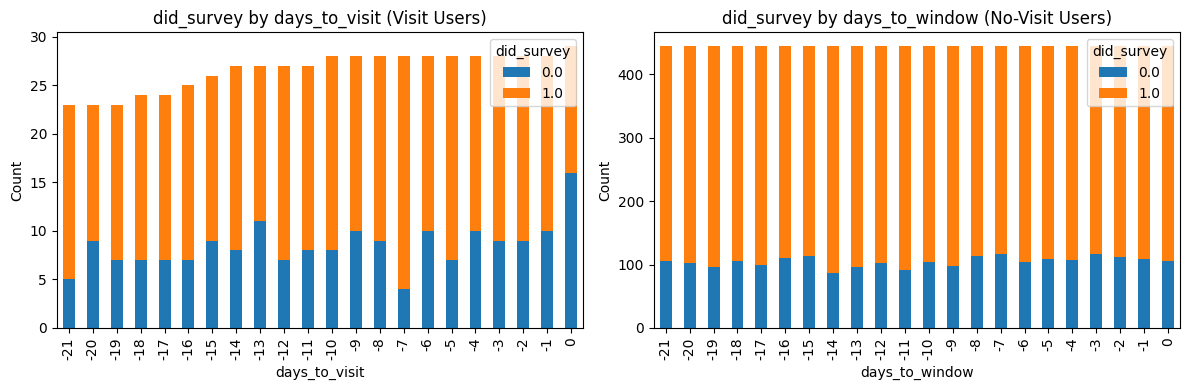

In [29]:
plot_feature_comparison(three_week_visit_app, three_week_app, 'did_survey', bin_continuous=False)

### 2b) Two Week

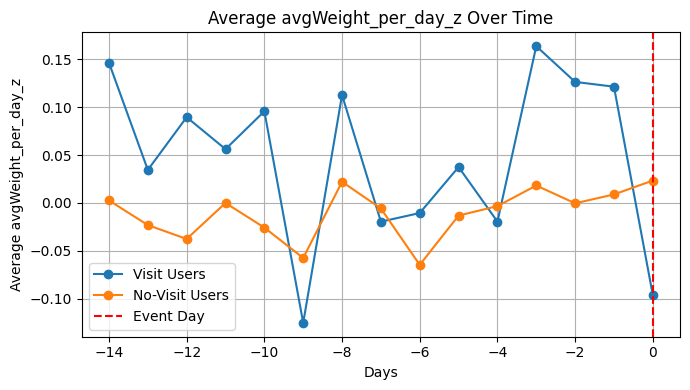

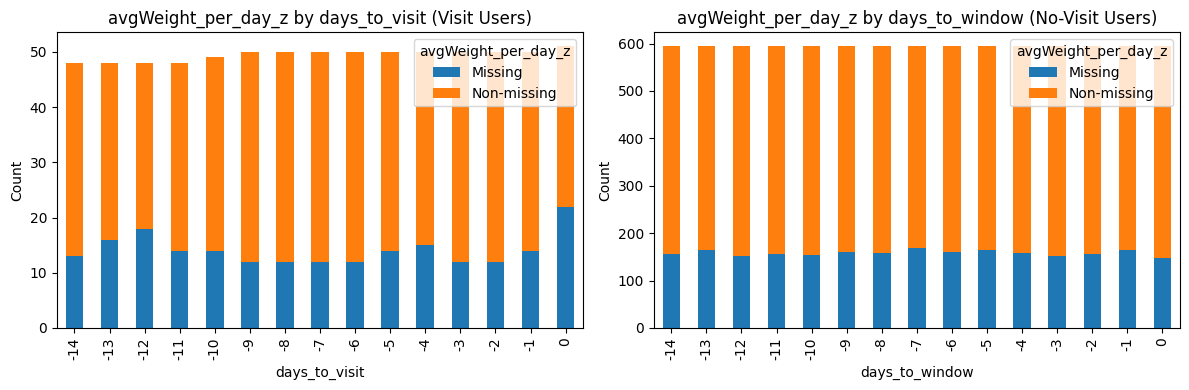

In [30]:
plot_feature_comparison(two_week_visit, two_week, 'avgWeight_per_day_z', bin_continuous=True, n_bins=10)

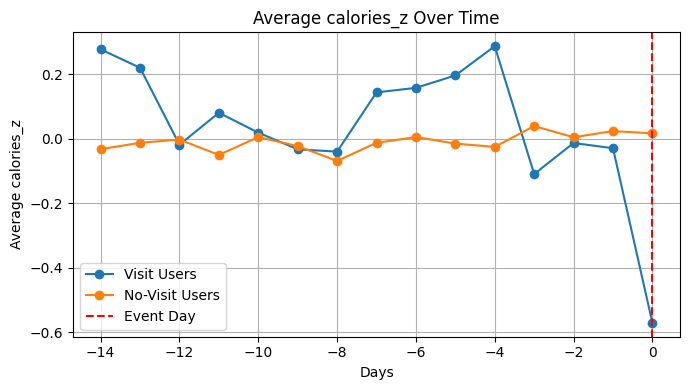

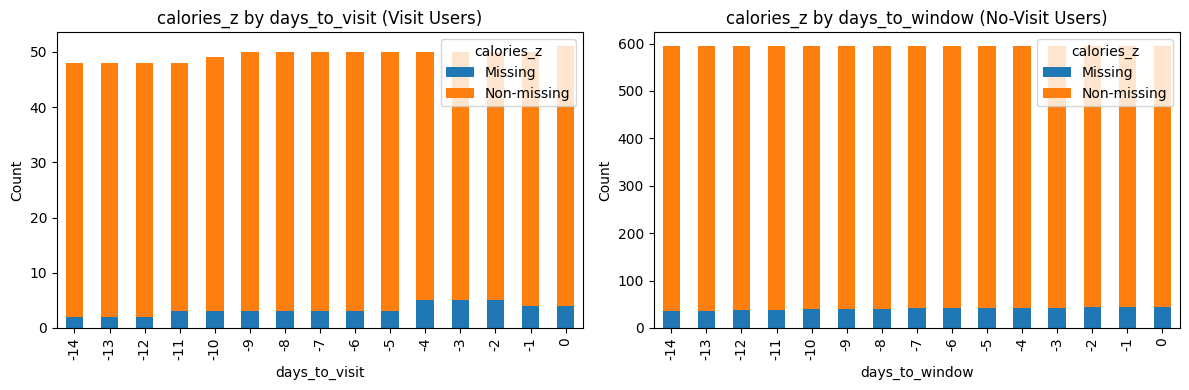

In [31]:
plot_feature_comparison(two_week_visit, two_week, 'calories_z', bin_continuous=True, n_bins=10)

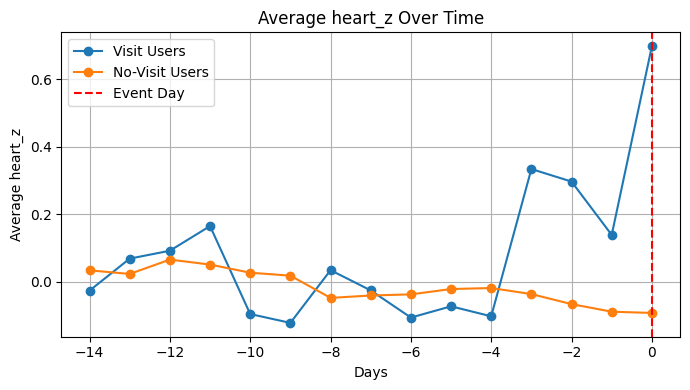

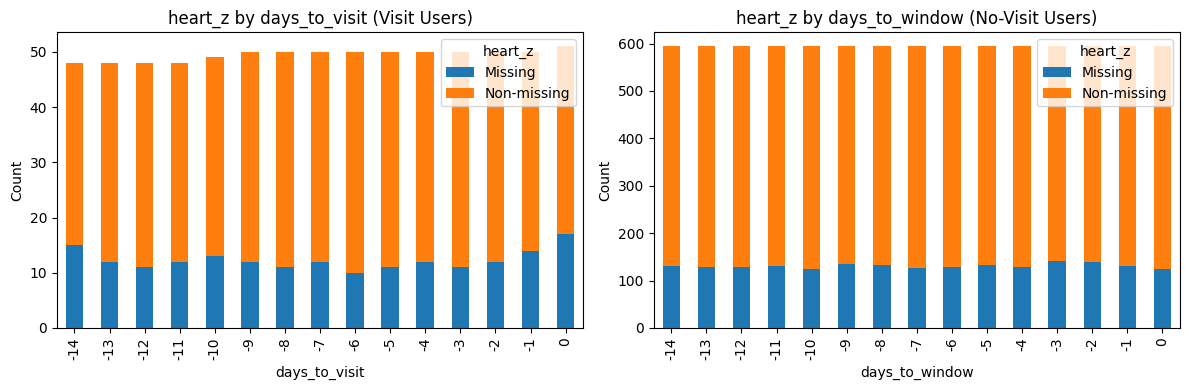

In [32]:
plot_feature_comparison(two_week_visit, two_week, 'heart_z', bin_continuous=True, n_bins=10)

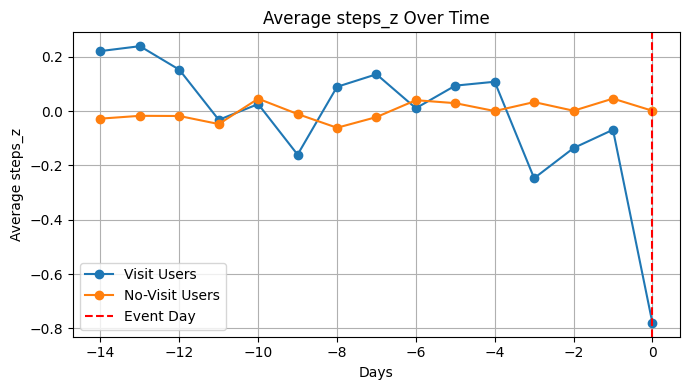

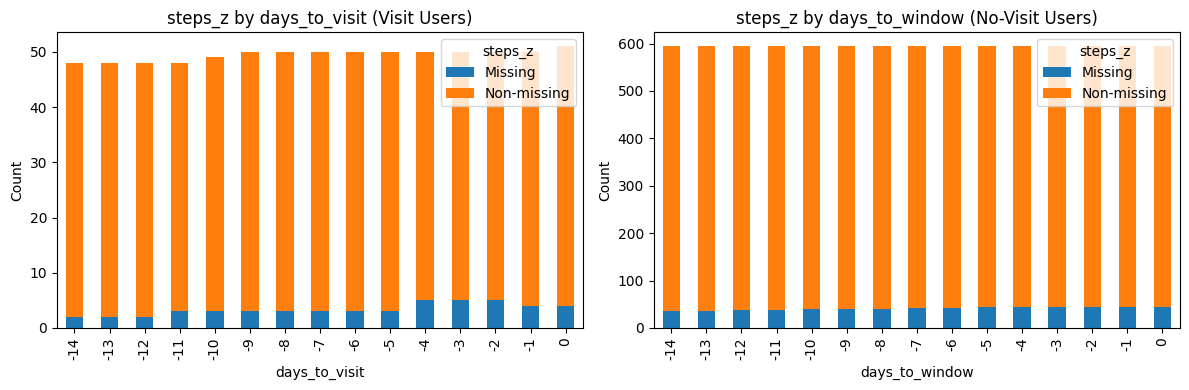

In [33]:
plot_feature_comparison(two_week_visit, two_week, 'steps_z', bin_continuous=True, n_bins=10)

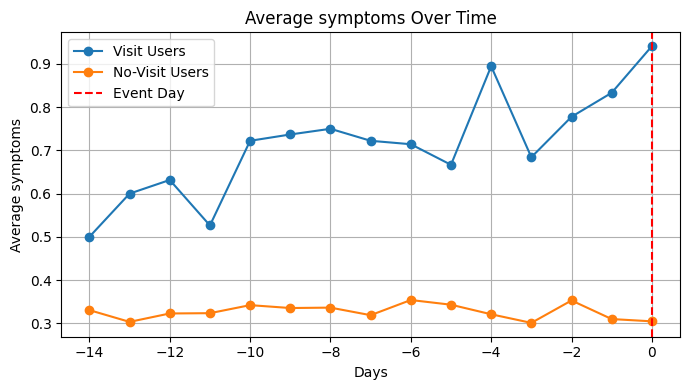

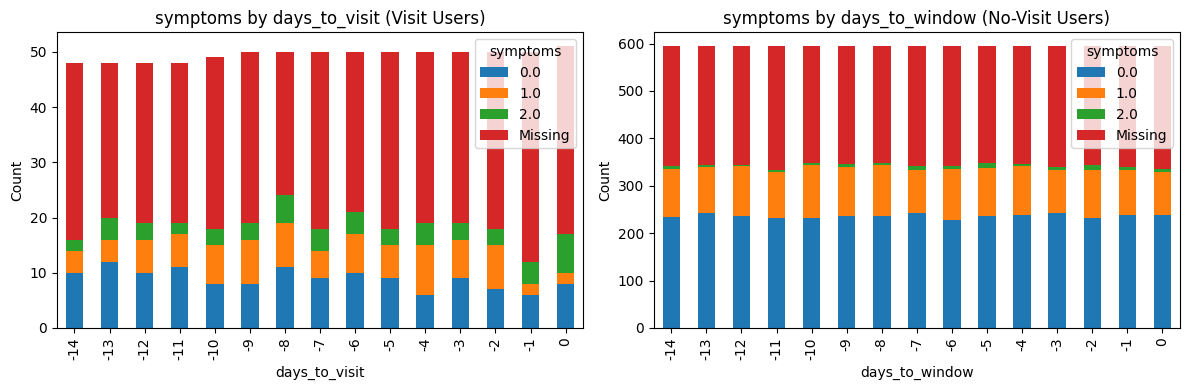

In [34]:
plot_feature_comparison(two_week_visit, two_week, 'symptoms', bin_continuous=False)

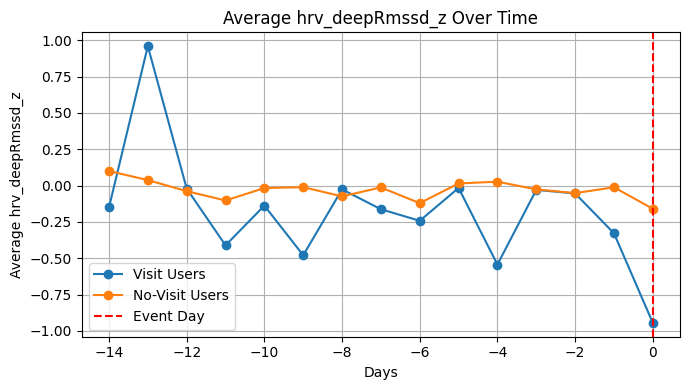

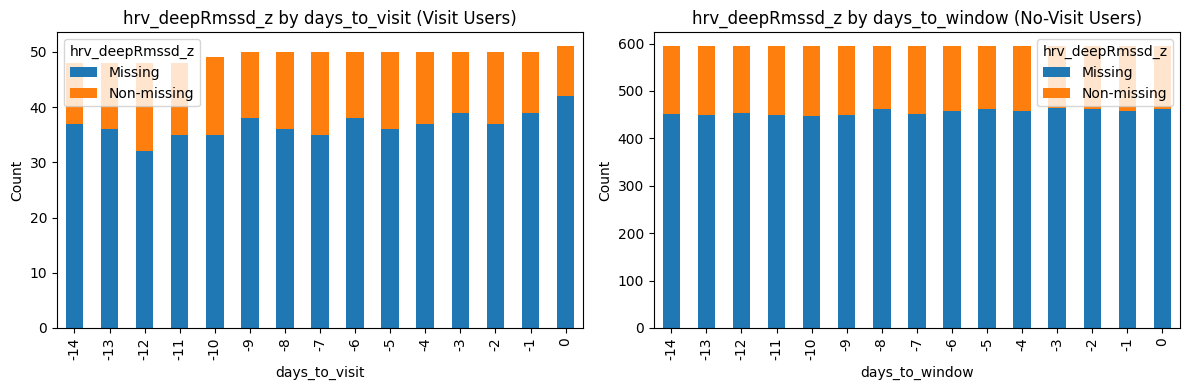

In [35]:
plot_feature_comparison(two_week_visit, two_week, 'hrv_deepRmssd_z', bin_continuous=True)

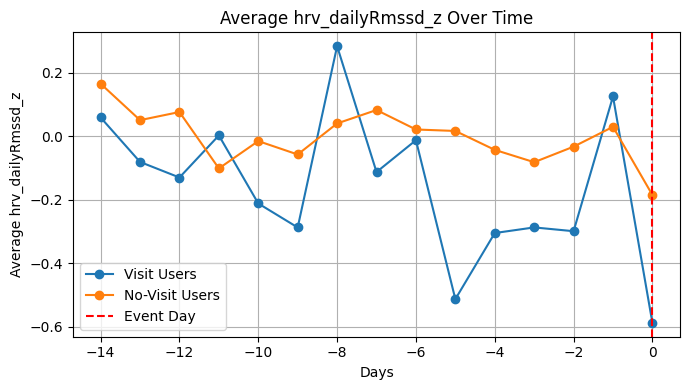

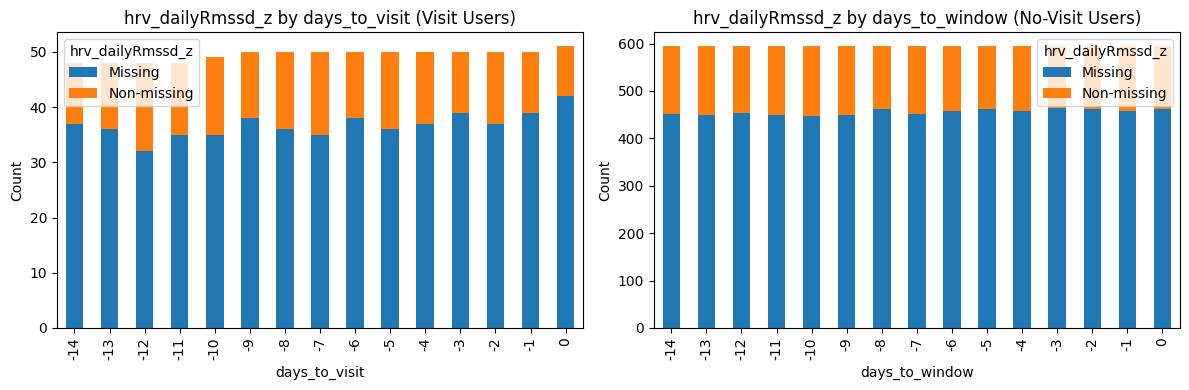

In [36]:
plot_feature_comparison(two_week_visit, two_week, 'hrv_dailyRmssd_z', bin_continuous=True)

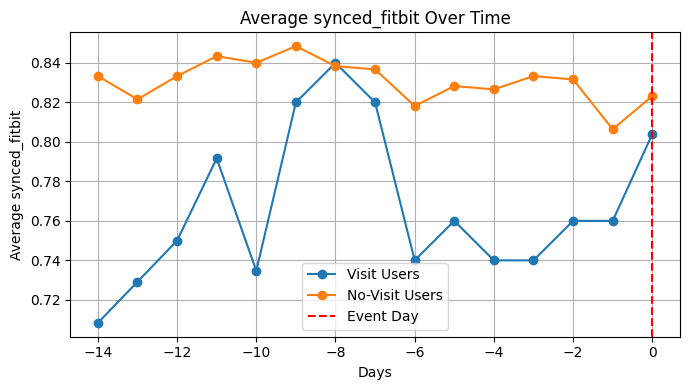

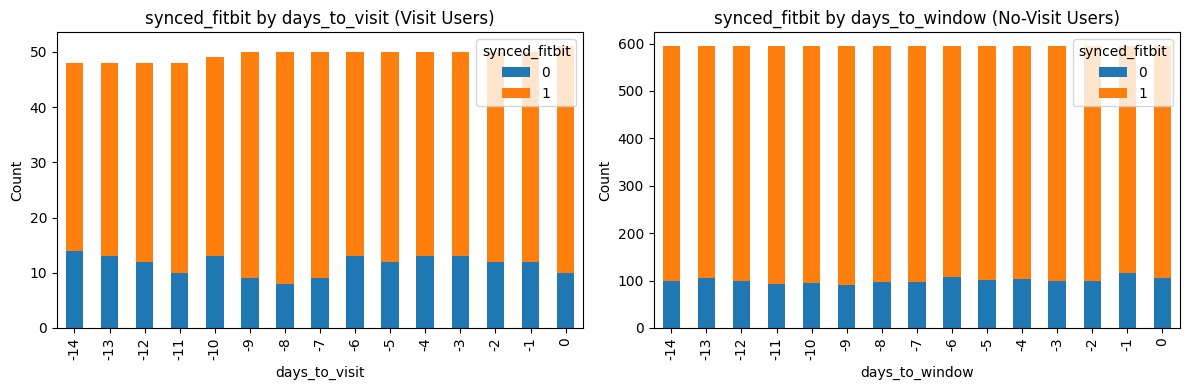

In [37]:
plot_feature_comparison(two_week_visit, two_week, 'synced_fitbit', bin_continuous=False)

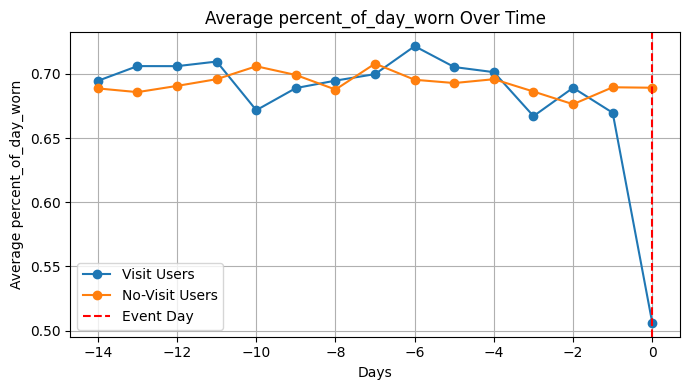

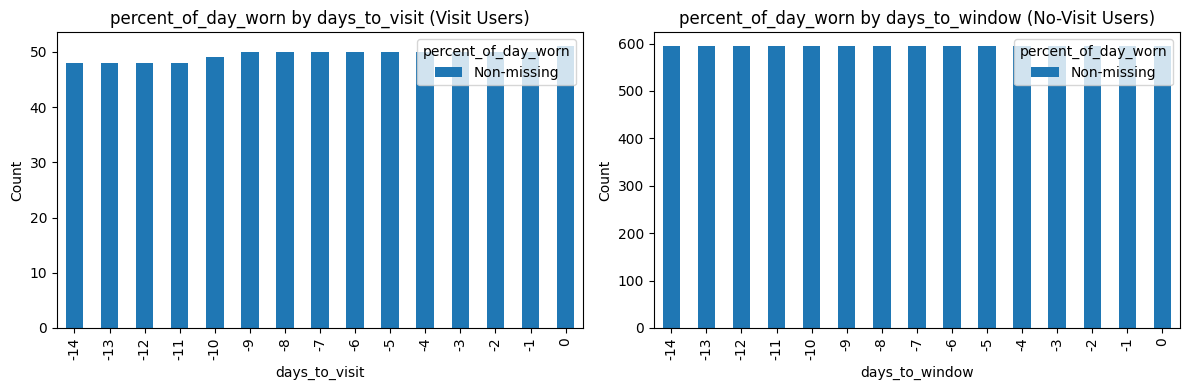

In [38]:
plot_feature_comparison(two_week_visit, two_week, 'percent_of_day_worn', bin_continuous=True)

In [39]:
two_week_visit_app = two_week_visit[two_week_visit['study_group'] != 'No App']
two_week_app = two_week[two_week['study_group'] != 'No App']

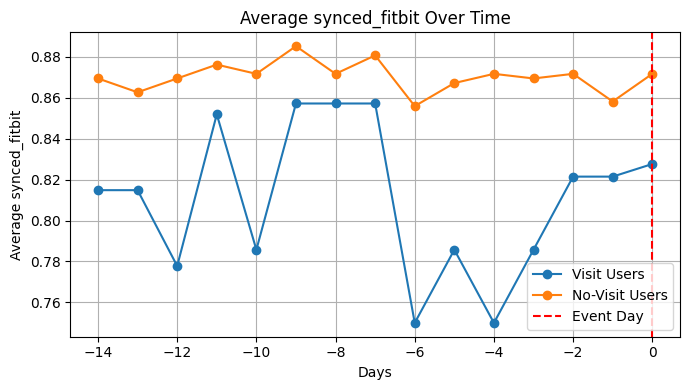

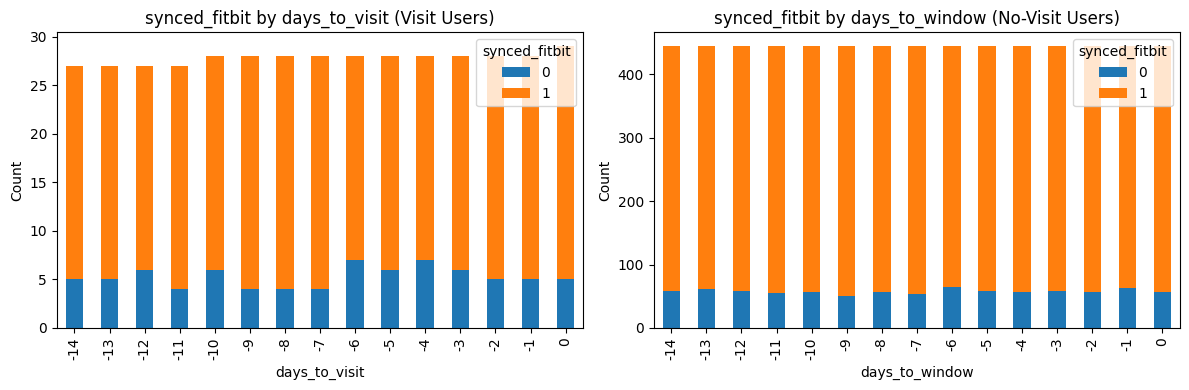

In [40]:
plot_feature_comparison(two_week_visit_app, two_week_app, 'synced_fitbit', bin_continuous=False)

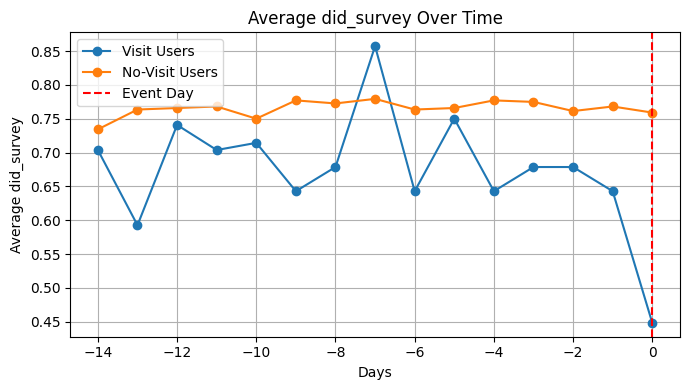

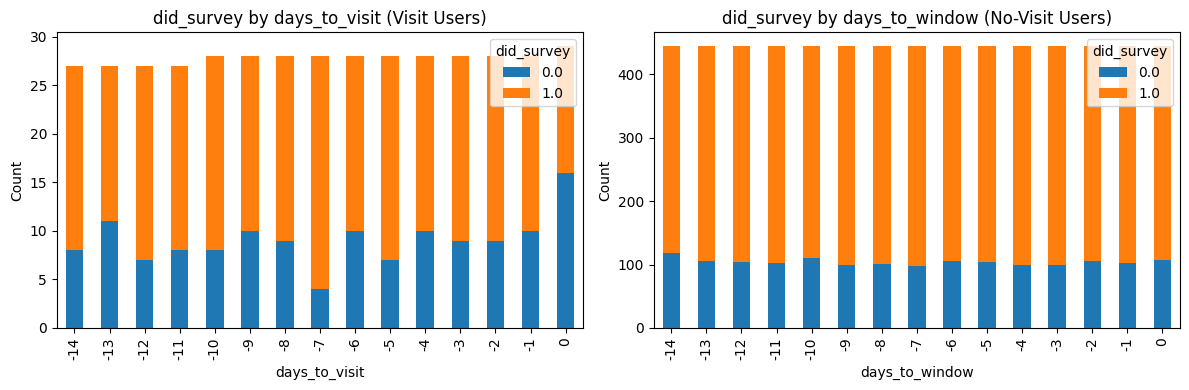

In [41]:
plot_feature_comparison(two_week_visit_app, two_week_app, 'did_survey', bin_continuous=False)